<a href="https://colab.research.google.com/github/young-hwanlee/stand_alone_deep_learning/blob/main/Assignment1_PyTorch_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
"""

'\n!pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)\n'

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


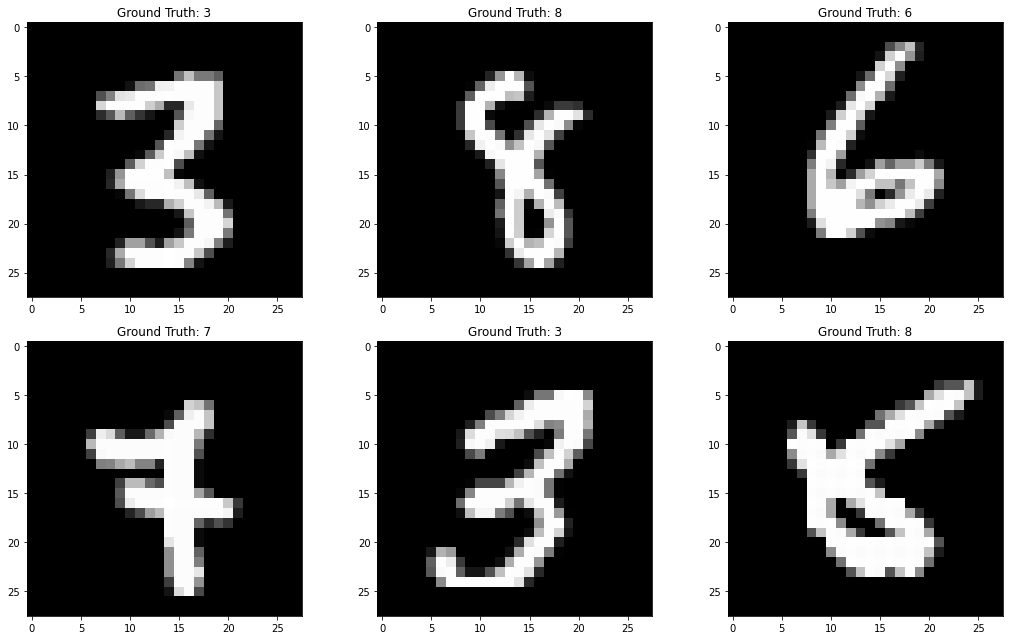

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [4]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

class MLPModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_nodes):
        super(MLPModel, self).__init__()
        nodes = (input_dim,) + hidden_nodes + (output_dim,)
        depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(depth - 1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        self.depth = depth
    
    def forward(self, x):
        for linear in self.linears:
            x = self.relu(linear(x))
        return x

In [5]:
cls_loss = nn.CrossEntropyLoss()

In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ---------------------------------------------------------------------------------------------------------------------------------------
import time
seed = 0

"""
# Python
import random
random.seed(seed)
"""

"""
# NumPy
import numpy as np
np.random.seed(seed)
"""

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# ---------------------------------------------------------------------------------------------------------------------------------------

# ====== Construct Model ====== #
model = MLPModel(input_dim=784, output_dim=10, hidden_nodes=(1000, 1000))
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ---------------------------------------------------------------------------------------------------------------------------------------
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
# ---------------------------------------------------------------------------------------------------------------------------------------

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

hist_epoch = [] 
hist_train_loss = []
hist_val_loss = []
hist_acc = []
hist_acc_epoch = []

epoch = 30
for i in range(epoch):
    # ------------------------------------------------------------------------------------------------------------------------------------
    time_start = time.time()
    # ------------------------------------------------------------------------------------------------------------------------------------

    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        # ---------------------------------------------------------------------------------------------------------------------------------
        input_X = input_X.to(device)
        true_y = true_y.to(device)
        # ---------------------------------------------------------------------------------------------------------------------------------
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        # train_loss += loss.detach().numpy()
        # ---------------------------------------------------------------------------------------------------------------------------------
        # train_loss += loss.detach().cpu().numpy()
        train_loss += loss.item()
        # ---------------------------------------------------------------------------------------------------------------------------------

    train_loss = train_loss / len(train_loader)
    hist_train_loss.append(train_loss)
    hist_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            # ------------------------------------------------------------------------------------------------------------------------------
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            # ------------------------------------------------------------------------------------------------------------------------------
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            # val_loss += loss.detach().numpy()
            # ------------------------------------------------------------------------------------------------------------------------------
            val_loss += loss.item()
            # ------------------------------------------------------------------------------------------------------------------------------

        val_loss = val_loss / len(val_loader)
        hist_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            # ------------------------------------------------------------------------------------------------------------------------------
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            # ------------------------------------------------------------------------------------------------------------------------------
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        # acc = correct.numpy() / len(test_loader.dataset)
        # ---------------------------------------------------------------------------------------------------------------------------------
        acc = correct.item() / len(test_loader.dataset)
        # ---------------------------------------------------------------------------------------------------------------------------------

        hist_acc.append(acc)
        hist_acc_epoch.append(i)
    
    # print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))
    # ------------------------------------------------------------------------------------------------------------------------------------
    time_end = time.time()
    print('Epoch: {}, Time: {:3.2f} seconds, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, time_end - time_start, train_loss, val_loss, acc*100))
    # ------------------------------------------------------------------------------------------------------------------------------------

Number of 1796010 parameters
Epoch: 0, Time: 15.24 seconds, Train Loss: 1.8396984000340142, Val Loss: 1.3387333516833149, Test Acc: 65.75999999999999%
Epoch: 1, Time: 11.26 seconds, Train Loss: 0.9568324273504565, Val Loss: 0.7687859120248239, Test Acc: 80.4%
Epoch: 2, Time: 11.78 seconds, Train Loss: 0.6793817339650811, Val Loss: 0.6423120045963722, Test Acc: 81.82000000000001%
Epoch: 3, Time: 11.29 seconds, Train Loss: 0.5952778874760698, Val Loss: 0.5878473207165923, Test Acc: 82.58%
Epoch: 4, Time: 12.13 seconds, Train Loss: 0.5533586890648698, Val Loss: 0.5549044284639479, Test Acc: 82.96%
Epoch: 5, Time: 11.44 seconds, Train Loss: 0.5262370534870021, Val Loss: 0.5330287433123286, Test Acc: 83.54%
Epoch: 6, Time: 11.26 seconds, Train Loss: 0.5068565767896754, Val Loss: 0.5157822596875927, Test Acc: 83.77%
Epoch: 7, Time: 11.06 seconds, Train Loss: 0.49097312228454043, Val Loss: 0.501930787216259, Test Acc: 84.09%
Epoch: 8, Time: 11.03 seconds, Train Loss: 0.4778809849258579, Val L

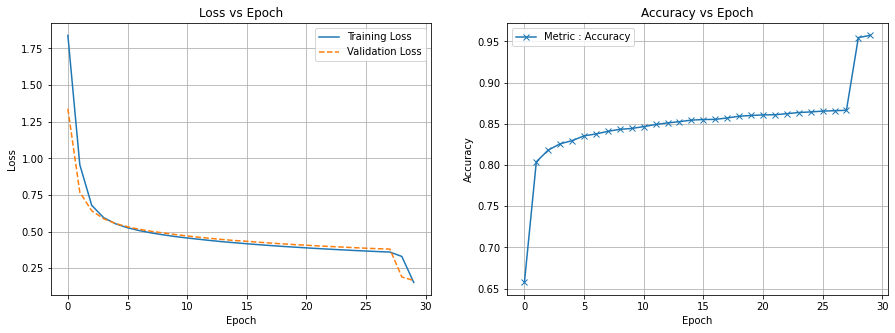

In [7]:
fig = plt.figure(figsize=(15,5))

# ===== Loss ===== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(hist_epoch, hist_train_loss, label='Training Loss')
ax1.plot(hist_epoch, hist_val_loss, '--', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
ax1.set_title('Loss vs Epoch')

# ===== Metric : Accuracy ===== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(hist_acc_epoch, hist_acc, marker='x', label='Metric : Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('Accuracy vs Epoch')

plt.show()